# Tectonic Model: basic functionality

The TectonicModel (`tm`) class is intended as versatile object in which the user can implement an initial plate conifiguation, as well as plate evolution.. 



Once created, the `tm` then provides a series of utilities to:

* set initial temperature distribution (plate/slab thermal model)
* implement and manage embedded faults
* map plate and plate boundary velocities to Underworld2 Stokes Systems
* map Underworld to Velocities and ( + gradients) back to the `tm` in order to update plate boundary information

In [2]:
import numpy as np
import underworld as uw
from underworld import function as fn
import glucifer
from easydict import EasyDict as edict
import networkx as nx
import operator
import UWsubduction as usub

## A toy model

In [3]:


mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1"), 
                                 elementRes  = (96, 48), 
                                 minCoord    = (-1.0, 0.0), 
                                 maxCoord    = (1.0, 1.0) )


temperatureField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
velocityField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=2 )
coordinate = fn.input()


In [4]:
#toy model, 3 plates


tm = usub.TectonicModel(mesh, 0, 20, 1)

tm.add_plate(1, velocities = 1)
tm.add_plate(2,velocities = -1)
tm.add_plate(3, velocities = 0)
        
tm.add_left_boundary(1)
tm.add_subzone(1, 2, 0.25, subInitAge=50.0, upperInitAge=10.0)
tm.add_ridge(2, 3, 0.5)
tm.add_right_boundary(3, 30.)

In [5]:
tm.is_subduction_boundary((1,2))

True

## The plate ID and age functions


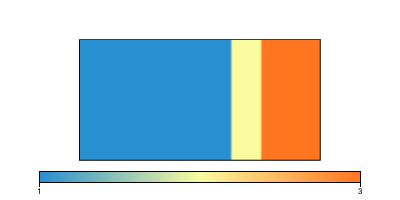

In [6]:

pIdFn = tm.plate_id_fn()
pAgeDict = tm.plate_age_fn() 

fnAge_map = fn.branching.map(fn_key = pIdFn , 
                          mapping = pAgeDict )

fig = glucifer.Figure(figsize=(400, 200))
fig.append( glucifer.objects.Surface(tm.mesh, pIdFn ))
fig.show()


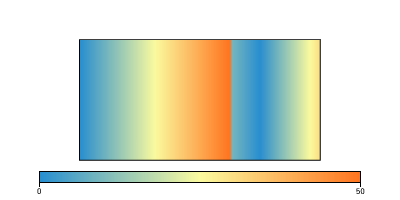

In [7]:
fig = glucifer.Figure(figsize=(400, 200))
fig.append( glucifer.objects.Surface(tm.mesh, fnAge_map ))
fig.show()

## Mask fuctions


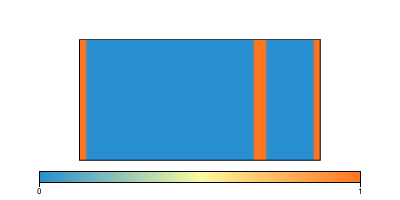

In [8]:
boundMaskFn = tm.plate_boundary_mask_fn(0.1)
RboundMaskFn = tm.ridge_mask_fn(0.05)
SboundMaskFn = tm.subduction_mask_fn(0.1)

#We can 'add' these mask functions like so
boundMaskFn = tm.combine_mask_fn(RboundMaskFn, SboundMaskFn )

fig = glucifer.Figure(figsize=(400, 200))
fig.append( glucifer.objects.Surface(tm.mesh, RboundMaskFn ))
fig.show()


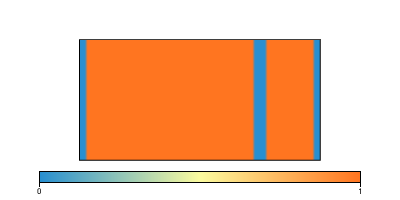

In [9]:
#It is also useful to be able invert mask fanctions

fig = glucifer.Figure(figsize=(400, 200))
fig.append( glucifer.objects.Surface(tm.mesh, tm.t2f(RboundMaskFn) ))
fig.show()


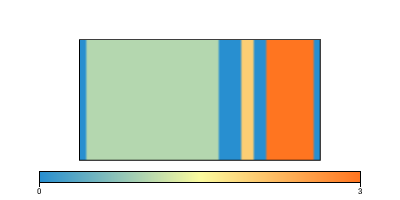

In [10]:
#We can also have  masked Plate Function 

maskedPlateIdFn = tm.plate_id_fn(maskFn=boundMaskFn)
fig = glucifer.Figure(figsize=(400, 200))
fig.append( glucifer.objects.Surface(tm.mesh, maskedPlateIdFn , valueRange = [0, 3] ))
fig.show()

## General queries

In [11]:

#We can traverse the undirect graph and use these functions to query the underlying directed data structue
for e in tm.undirected.edges():
    print(tm.is_ridge(e), tm.is_subduction_boundary(e))
    e = (e[1], e[0])
    print(tm.is_ridge(e), tm.is_subduction_boundary(e))

True False
True False
False True
False True
True False
True False
True False
True False
